In [1]:
# Imports
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
import pprint as pp
import numpy as np
from typing import Optional
from utils import (
    FactorModel, ApiData, Logger, API_KEY,
    get_risk_free_rate, fetch_merged_crypto_data,
    cumulative_returns, calculate_annualized_return,
    plot_cumulative_returns, convert_to_log_returns,
)
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
import os
import yfinance as yf
import matplotlib.ticker as mtick

from utils import cumulative_returns, calculate_annualized_return, plot_cumulative_returns, convert_to_log_returns


Momentum v1 - equal weighting; absolute return ranked;


In [ ]:
# Momentum V1 Factor Code

In [ ]:

# momentum = FactorModel(df=df, factor='momentum', breakpoint=0.25, min_assets=30, weighting_method='equal')

# momentum_metric_agg_method_map = {
#     'price': 'last',
#     'mc': 'last',
#     '24h_volume': 'sum',
# }

# momentum_lookback_periods = 3

# momentum.resample('W', momentum_metric_agg_method_map)
# momentum.calculate_price_pct_change(periods=1)
# momentum.calculate_price_pct_change(periods=momentum_lookback_periods)
# # apply t_minus_1 calculations here
# momentum.get_t_minus_1_metrics(metrics=['mc', '24h_volume', f'price_pct_change_p{momentum_lookback_periods}']) # t minus 1 for mc and 24h_volume
# # apply eligibility criteria after calculating metrics
# momentum.market_cap_threshold(threshold=100000000) # 100,000,000
# momentum.liquidity_threshold(threshold=35000000) # $5M / day
# momentum.minimum_lifetime(days=30)


# for date, group in momentum.df.groupby('date'):
#     momentum_group = group.dropna(subset=['mc_t_minus_1', 'price_pct_change_p1', f'price_pct_change_p{momentum_lookback_periods}_t_minus_1'])
#     high_momentum = momentum_group.nlargest(int(len(momentum_group) * momentum.breakpoint), f'price_pct_change_p{momentum_lookback_periods}_t_minus_1')
#     low_momentum = momentum_group.nsmallest(int(len(momentum_group) * momentum.breakpoint), f'price_pct_change_p{momentum_lookback_periods}_t_minus_1')

#     if len(low_momentum) < momentum.min_assets / 2 and len(high_momentum) < momentum.min_assets / 2:
#         continue
#     else:
#         if momentum.weighting_method == 'equal':
#             weighted_avg = lambda df: df['price_pct_change_p1'].mean() # equal weighted avg returns
#         elif momentum.weighting_method == 'market_cap':
#             weighted_avg = lambda df: (df['mc_t_minus_1'] * df['price_pct_change_p1']).sum() / df['mc_t_minus_1'].sum()
#         else: 
#             raise ValueError(f"Invalid weighting method: {momentum.weighting_method}")
            
#         long_asset_details = {}
#         short_asset_details = {}
#         # iterate through small and parse out asset and weighting
#         for _, row in high_momentum.iterrows():
#             asset = row['asset']
#             if momentum.weighting_method == 'equal':
#                 weighting = 1 / len(high_momentum)
#             elif momentum.weighting_method == 'market_cap':
#                 weighting = row['mc_t_minus_1'] / high_momentum['mc_t_minus_1'].sum()
#             else:
#                 raise ValueError(f"Invalid weighting method: {momentum.weighting_method}")

#             long_asset_details[asset] = {'weighting': weighting, 'price_pct_change': row['price_pct_change_p1'], 'trailing_price_pct_change': row[f'price_pct_change_p{momentum_lookback_periods}_t_minus_1']}

#         for _, row in low_momentum.iterrows():
#             asset = row['asset']
#             if momentum.weighting_method == 'equal':
#                 weighting = 1 / len(low_momentum)
#             elif momentum.weighting_method == 'market_cap':
#                 weighting = row['mc_t_minus_1'] / low_momentum['mc_t_minus_1'].sum()
#             else:
#                 raise ValueError(f"Invalid weighting method: {momentum.weighting_method}")

#             short_asset_details[asset] = {'weighting': weighting, 'price_pct_change': row['price_pct_change_p1'], 'trailing_price_pct_change': row[f'price_pct_change_p{momentum_lookback_periods}_t_minus_1']}
        
#         momentum.factor_assets[date] = {
#             'long_portfolio': long_asset_details,
#             'short_portfolio': short_asset_details
#         }

#         momentum.factor_returns[date] = weighted_avg(high_momentum) - weighted_avg(low_momentum)
#         momentum.long_portfolio_returns[date] = weighted_avg(high_momentum)
#         momentum.short_portfolio_returns[date] = weighted_avg(low_momentum)
        
# momentum_factor_asset_cnts = {}
# for key in momentum.factor_assets.keys():
#     momentum_factor_asset_cnts[key] = len(momentum.factor_assets[key]['long_portfolio']) + len(momentum.factor_assets[key]['short_portfolio'])


# momentum_returns_df = cumulative_returns(momentum.factor_returns)
# momentum_long_only_returns_df = cumulative_returns(momentum.long_portfolio_returns)
# momentum_short_only_returns_df = cumulative_returns(momentum.short_portfolio_returns)

# sharpe_ratio = (momentum_returns_df['value'].mean() / momentum_returns_df['value'].std()) * np.sqrt(52)


# print(sharpe_ratio)

# momentum_annualized_return, momentum_cumulative_returns, momentum_years = calculate_annualized_return(momentum, momentum_returns_df)

# momentum.results_dict = {
#     'cumulative_returns': momentum_cumulative_returns,
#     'annualized_return': momentum_annualized_return,
#     'years': momentum_years,
#     'long_only_returns': momentum_long_only_returns_df['cumulative_returns'].iloc[-1],
#     'short_only_returns': momentum_short_only_returns_df['cumulative_returns'].iloc[-1],
#     'trailing_momentum_lookback_periods': momentum_lookback_periods,
#     'sharpe_ratio': sharpe_ratio
# }

# plot_cumulative_returns(momentum_returns_df, momentum)

# momentum_logger = Logger(log_dir='factor_logs', factor_model=momentum)
# momentum_logger.log_results(momentum.results_dict)

In [ ]:
# # Momentum v3: long only signal based 
# # momentum factor
# momentum_v3 = FactorModel(df=df, factor='momentum_v3', breakpoint=0.25, min_assets=15, weighting_method='equal')

# momentum_lookback_periods = 3
# daily_lookback_period = momentum_lookback_periods * 7

# # for each asset, find the trailing daily_lookback_period vol score
# def calculate_metrics(group):
#     group['price_pct_change'] = group['price'].pct_change()
#     # Rolling volatility adjustment
#     # Mean return / std of returns over lookback period
#     rolling_mean = group['price_pct_change'].rolling(
#         window=daily_lookback_period,
#         min_periods=daily_lookback_period
#     ).mean()
    
#     rolling_std = group['price_pct_change'].rolling(
#         window=daily_lookback_period,
#         min_periods=daily_lookback_period
#     ).std()
    
#     # Vol ratio (handle division by zero); Essentially a sharpe ratio
#     group['vol_ratio'] = np.where(
#         rolling_std > 0,
#         np.abs(rolling_mean) / rolling_std,
#         0
#     )
    
#     # Normalize vol_ratio to 0-1 range (cap at 1.0)
#     group['vol_score'] = group['vol_ratio'] # np.clip(group['vol_ratio'] / 2.0, 0, 1)
    
#     # Calculate raw momentum (compound return over lookback)
#     group['raw_momentum'] = group['price_pct_change'].rolling(
#         window=daily_lookback_period,
#         min_periods=daily_lookback_period
#     ).apply(lambda x: (1 + x).prod() - 1, raw=True)

#     group['filtered_momentum'] = group['raw_momentum'] * group['vol_score']
    
#     return group

# momentum_v3.df = momentum_v3.df.groupby('asset', group_keys=False).apply(calculate_metrics)

# momentum_metric_agg_method_map = {
#     'price': 'last',
#     'mc': 'last',
#     '24h_volume': 'sum',
#     'vol_score': 'last',
#     'filtered_momentum': 'last',
# }

# momentum_v3.resample('W', momentum_metric_agg_method_map)
# momentum_v3.calculate_price_pct_change(periods=1)
# momentum_v3.calculate_price_pct_change(periods=momentum_lookback_periods)

# # apply t_minus_1 calculations here
# momentum_v3.get_t_minus_1_metrics(metrics=['mc', '24h_volume', f'price_pct_change_p{momentum_lookback_periods}', 'vol_score', 'filtered_momentum']) # t minus 1 for mc and 24h_volume
# # apply eligibility criteria after calculating metrics
# momentum_v3.market_cap_threshold(threshold=100000000) # 100,000,000
# momentum_v3.liquidity_threshold(threshold=35000000) # $5M / day
# momentum_v3.minimum_lifetime(days=30)
# market_returns_df['50_sma'] = market_returns_df['cumulative_returns'].rolling(window=50).mean()
# market_returns_df['200_sma'] = market_returns_df['cumulative_returns'].rolling(window=200).mean()
# market_returns_df['bullish_trend_signal'] = np.where(market_returns_df['cumulative_returns'] > market_returns_df['50_sma'], 1, 0)
# momentum_v3.df = momentum_v3.df.merge(market_returns_df, on='date', how='left')

# for date, group in momentum_v3.df.groupby('date'):
#     momentum_group = group.dropna(subset=['mc_t_minus_1', 'price_pct_change_p1', f'price_pct_change_p{momentum_lookback_periods}_t_minus_1', 'filtered_momentum_t_minus_1'])
#     high_momentum = momentum_group.nlargest(int(len(momentum_group) * momentum_v3.breakpoint), 'filtered_momentum_t_minus_1') #f'price_pct_change_p{momentum_lookback_periods}_t_minus_1')
#     low_momentum = momentum_group.nsmallest(int(len(momentum_group) * momentum_v3.breakpoint), 'filtered_momentum_t_minus_1') #f'price_pct_change_p{momentum_lookback_periods}_t_minus_1')

#     if len(high_momentum) < momentum_v3.min_assets:
#         continue
#     else:
#         if momentum_v3.weighting_method == 'equal':
#             weighted_avg = lambda df: df['price_pct_change_p1'].mean() # equal weighted avg returns
#         elif momentum_v3.weighting_method == 'market_cap':
#             weighted_avg = lambda df: (df['mc_t_minus_1'] * df['price_pct_change_p1']).sum() / df['mc_t_minus_1'].sum()
#         else: 
#             raise ValueError(f"Invalid weighting method: {momentum_v3.weighting_method}")
            
#         long_asset_details = {}
#         # iterate through small and parse out asset and weighting
#         for _, row in high_momentum.iterrows():
#             asset = row['asset']
#             if momentum_v3.weighting_method == 'equal':
#                 weighting = 1 / len(high_momentum)
#             elif momentum_v3.weighting_method == 'market_cap':
#                 weighting = row['mc_t_minus_1'] / high_momentum['mc_t_minus_1'].sum()
#             else:
#                 raise ValueError(f"Invalid weighting method: {momentum_v3.weighting_method}")

#             long_asset_details[asset] = {'weighting': weighting, 'price_pct_change': row['price_pct_change_p1'], 'trailing_price_pct_change': row[f'price_pct_change_p{momentum_lookback_periods}_t_minus_1'], 'filtered_momentum': row['filtered_momentum_t_minus_1']}

#         momentum_v3.factor_assets[date] = {
#             'long_portfolio': long_asset_details
#         }
        
#         # momentum_v3.factor_returns[date] = weighted_avg(high_momentum) - weighted_avg(low_momentum)
#         # momentum_v3.long_portfolio_returns[date] = weighted_avg(high_momentum)
#         # momentum_v3.short_portfolio_returns[date] = weighted_avg(low_momentum)

#         momentum_v3.factor_returns[date] = np.where(group['bullish_trend_signal'].iloc[0] == 1, weighted_avg(high_momentum), 0)
#         momentum_v3.long_portfolio_returns[date] = np.where(group['bullish_trend_signal'].iloc[0] == 1, weighted_avg(high_momentum), 0)
        
# momentum_factor_asset_cnts = {}
# for key in momentum_v3.factor_assets.keys():
#     momentum_factor_asset_cnts[key] = len(momentum_v3.factor_assets[key]['long_portfolio'])


# momentum_raw_returns_df = pd.DataFrame({
#     'date': list(momentum_v3.factor_returns.keys()),
#     'momentum_v3': list(momentum_v3.factor_returns.values())
# }).set_index('date')


# momentum_returns_df = cumulative_returns(momentum_v3.factor_returns)
# momentum_long_only_returns_df = cumulative_returns(momentum_v3.long_portfolio_returns)


# sharpe_ratio = momentum_raw_returns_df['momentum_v3'].mean() / momentum_raw_returns_df['momentum_v3'].std()
# print(sharpe_ratio)

# momentum_v3_downside_returns = momentum_raw_returns_df[momentum_raw_returns_df['momentum_v3'] < 0]
# sortino_ratio = momentum_raw_returns_df['momentum_v3'].mean() / momentum_v3_downside_returns['momentum_v3'].std()
# print(f"Sortino ratio: {sortino_ratio}")

# plot_cumulative_returns(momentum_returns_df, momentum_factor_asset_cnts)
# momentum_annualized_return, momentum_cumulative_returns, momentum_years = calculate_annualized_return(momentum_v3, momentum_returns_df)

# momentum_results_dict = {
#     'cumulative_returns': momentum_cumulative_returns,
#     'annualized_return': momentum_annualized_return,
#     'years': momentum_years,
#     'long_only_returns': momentum_long_only_returns_df['cumulative_returns'].iloc[-1],
#     'trailing_momentum_lookback_periods': momentum_lookback_periods,
#     'sharpe_ratio': sharpe_ratio
# }

# # momentum_logger = Logger(log_dir='factor_logs', factor_model=momentum)
# # momentum_logger.log_results(momentum_results_dict)

In [ ]:
# # Momentum v4 binary long-only short-only signal based momentum
# # momentum factor
# momentum_v3 = FactorModel(df=df, factor='momentum_v3', breakpoint=0.25, min_assets=15, weighting_method='equal')

# momentum_lookback_periods = 3
# daily_lookback_period = momentum_lookback_periods * 7

# # for each asset, find the trailing daily_lookback_period vol score
# def calculate_metrics(group):
#     group['price_pct_change'] = group['price'].pct_change()
#     # Rolling volatility adjustment
#     # Mean return / std of returns over lookback period
#     rolling_mean = group['price_pct_change'].rolling(
#         window=daily_lookback_period,
#         min_periods=daily_lookback_period
#     ).mean()
    
#     rolling_std = group['price_pct_change'].rolling(
#         window=daily_lookback_period,
#         min_periods=daily_lookback_period
#     ).std()
    
#     # Vol ratio (handle division by zero); Essentially a sharpe ratio
#     group['vol_ratio'] = np.where(
#         rolling_std > 0,
#         np.abs(rolling_mean) / rolling_std,
#         0
#     )
    
#     # Normalize vol_ratio to 0-1 range (cap at 1.0)
#     group['vol_score'] = group['vol_ratio'] # np.clip(group['vol_ratio'] / 2.0, 0, 1)
    
#     # Calculate raw momentum (compound return over lookback)
#     group['raw_momentum'] = group['price_pct_change'].rolling(
#         window=daily_lookback_period,
#         min_periods=daily_lookback_period
#     ).apply(lambda x: (1 + x).prod() - 1, raw=True)

#     group['filtered_momentum'] = group['raw_momentum'] * group['vol_score']
    
#     return group

# momentum_v3.df = momentum_v3.df.groupby('asset', group_keys=False).apply(calculate_metrics)

# momentum_metric_agg_method_map = {
#     'price': 'last',
#     'mc': 'last',
#     '24h_volume': 'sum',
#     'vol_score': 'last',
#     'filtered_momentum': 'last',
# }

# momentum_v3.resample('W', momentum_metric_agg_method_map)
# momentum_v3.calculate_price_pct_change(periods=1)
# momentum_v3.calculate_price_pct_change(periods=momentum_lookback_periods)

# # apply t_minus_1 calculations here
# momentum_v3.get_t_minus_1_metrics(metrics=['mc', '24h_volume', f'price_pct_change_p{momentum_lookback_periods}', 'vol_score', 'filtered_momentum']) # t minus 1 for mc and 24h_volume
# # apply eligibility criteria after calculating metrics
# momentum_v3.market_cap_threshold(threshold=100000000) # 100,000,000
# momentum_v3.liquidity_threshold(threshold=35000000) # $5M / day
# momentum_v3.minimum_lifetime(days=30)
# market_returns_df['50_sma'] = market_returns_df['cumulative_returns'].rolling(window=50).mean()
# market_returns_df['200_sma'] = market_returns_df['cumulative_returns'].rolling(window=200).mean()
# market_returns_df['bullish_trend_signal'] = np.where(market_returns_df['cumulative_returns'] > market_returns_df['50_sma'], 1, 0)
# momentum_v3.df = momentum_v3.df.merge(market_returns_df, on='date', how='left')

# for date, group in momentum_v3.df.groupby('date'):
#     momentum_group = group.dropna(subset=['mc_t_minus_1', 'price_pct_change_p1', f'price_pct_change_p{momentum_lookback_periods}_t_minus_1', 'filtered_momentum_t_minus_1'])
#     high_momentum = momentum_group.nlargest(int(len(momentum_group) * momentum_v3.breakpoint), 'filtered_momentum_t_minus_1') #f'price_pct_change_p{momentum_lookback_periods}_t_minus_1')
#     low_momentum = momentum_group.nsmallest(int(len(momentum_group) * momentum_v3.breakpoint), 'filtered_momentum_t_minus_1') #f'price_pct_change_p{momentum_lookback_periods}_t_minus_1')

#     if len(high_momentum) < momentum_v3.min_assets or len(low_momentum) < momentum_v3.min_assets:
#         continue
#     else:
#         if momentum_v3.weighting_method == 'equal':
#             weighted_avg = lambda df: df['price_pct_change_p1'].mean() # equal weighted avg returns
#         elif momentum_v3.weighting_method == 'market_cap':
#             weighted_avg = lambda df: (df['mc_t_minus_1'] * df['price_pct_change_p1']).sum() / df['mc_t_minus_1'].sum()
#         else: 
#             raise ValueError(f"Invalid weighting method: {momentum_v3.weighting_method}")
            
#         long_asset_details = {}
#         # iterate through small and parse out asset and weighting
#         for _, row in high_momentum.iterrows():
#             asset = row['asset']
#             if momentum_v3.weighting_method == 'equal':
#                 weighting = 1 / len(high_momentum)
#             elif momentum_v3.weighting_method == 'market_cap':
#                 weighting = row['mc_t_minus_1'] / high_momentum['mc_t_minus_1'].sum()
#             else:
#                 raise ValueError(f"Invalid weighting method: {momentum_v3.weighting_method}")

#             long_asset_details[asset] = {'weighting': weighting, 'price_pct_change': row['price_pct_change_p1'], 'trailing_price_pct_change': row[f'price_pct_change_p{momentum_lookback_periods}_t_minus_1'], 'filtered_momentum': row['filtered_momentum_t_minus_1']}

            
#         short_asset_details = {}
#         # iterate through small and parse out asset and weighting
#         for _, row in low_momentum.iterrows():
#             asset = row['asset']
#             if momentum_v3.weighting_method == 'equal':
#                 weighting = 1 / len(low_momentum)
#             elif momentum_v3.weighting_method == 'market_cap':
#                 weighting = row['mc_t_minus_1'] / low_momentum['mc_t_minus_1'].sum()
#             else:
#                 raise ValueError(f"Invalid weighting method: {momentum_v3.weighting_method}")

#             short_asset_details[asset] = {'weighting': weighting, 'price_pct_change': row['price_pct_change_p1'], 'trailing_price_pct_change': row[f'price_pct_change_p{momentum_lookback_periods}_t_minus_1'], 'filtered_momentum': row['filtered_momentum_t_minus_1']}

#         momentum_v3.factor_assets[date] = {
#             'long_portfolio': long_asset_details,
#             'short_portfolio': short_asset_details
#         }
        
#         # momentum_v3.factor_returns[date] = weighted_avg(high_momentum) - weighted_avg(low_momentum)
#         # momentum_v3.long_portfolio_returns[date] = weighted_avg(high_momentum)
#         # momentum_v3.short_portfolio_returns[date] = weighted_avg(low_momentum)

#         momentum_v3.factor_returns[date] = np.where(group['bullish_trend_signal'].iloc[0] == 1, weighted_avg(high_momentum), (weighted_avg(high_momentum) * -1))
#         # momentum_v3.long_portfolio_returns[date] = np.where(group['bullish_trend_signal'].iloc[0] == 1, weighted_avg(high_momentum), 0)

        
# momentum_factor_asset_cnts = {}
# for key in momentum_v3.factor_assets.keys():
#     momentum_factor_asset_cnts[key] = len(momentum_v3.factor_assets[key]['long_portfolio'])
#     momentum_factor_asset_cnts[key] += len(momentum_v3.factor_assets[key]['short_portfolio'])


# momentum_raw_returns_df = pd.DataFrame({
#     'date': list(momentum_v3.factor_returns.keys()),
#     'momentum_v3': list(momentum_v3.factor_returns.values())
# }).set_index('date')


# momentum_returns_df = cumulative_returns(momentum_v3.factor_returns)
# # momentum_long_only_returns_df = cumulative_returns(momentum_v3.long_portfolio_returns)


# sharpe_ratio = momentum_raw_returns_df['momentum_v3'].mean() / momentum_raw_returns_df['momentum_v3'].std()
# print(sharpe_ratio)

# momentum_v3_downside_returns = momentum_raw_returns_df[momentum_raw_returns_df['momentum_v3'] < 0]
# sortino_ratio = momentum_raw_returns_df['momentum_v3'].mean() / momentum_v3_downside_returns['momentum_v3'].std()
# print(f"Sortino ratio: {sortino_ratio}")

# plot_cumulative_returns(momentum_returns_df, momentum_factor_asset_cnts)
# momentum_annualized_return, momentum_cumulative_returns, momentum_years = calculate_annualized_return(momentum_v3, momentum_returns_df)

# momentum_results_dict = {
#     'cumulative_returns': momentum_cumulative_returns,
#     'annualized_return': momentum_annualized_return,
#     'years': momentum_years,
#     'long_only_returns': momentum_long_only_returns_df['cumulative_returns'].iloc[-1],
#     'trailing_momentum_lookback_periods': momentum_lookback_periods,
#     'sharpe_ratio': sharpe_ratio
# }

# # momentum_logger = Logger(log_dir='factor_logs', factor_model=momentum)
# # momentum_logger.log_results(momentum_results_dict)

Risk Free Rate Code

In [4]:
# Risk-free rate via yfinance (^IRX 13-week T-bill)
rf_df = get_risk_free_rate()

# Resample to weekly for consistency with factor model frequency
rf_df_weekly = rf_df.resample('W').last().dropna()
rf_df_weekly.head()


 pip install snowflake-connector-python[secure-local-storage]
/Users/varun/github/gokustats-back-end/venv-factor-models/lib/python3.9/site-packages/boto3/compat.py:84: PythonDeprecationWarning: Boto3 will no longer support Python 3.9 starting April 29, 2026. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.10 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://accounts.google.com/o/saml2/idp?idpid=C00rimqke&SAMLRequest=lZJLb%2BIwFIX%2FSuRZJ3YChdYiIB5Ck5lAKYS2052bGOrBsYMfTfvvxyEgdRat1IUlyz7H370%2BdzB6K7n3SpVmUsQgDBDwqMhlwcQ%2BBtts7l8DTxsiCsKloDF4pxqMhgNNSl7hsTUvYk2PlmrjuYeExs1FDKwSWBLNNBakpBqbHG%2FGixRHAcJEa6qMw4GzpdDMsV6MqTCEdV0HdSeQag8jhBBEN9CpGskP8AFRfc2olDQyl%2FxieXM9fYIIIeo2CKdwhNXZOGGi%2FYKvKM%2BtSOOfWbbyV7ebDHjjS3dTKbQtqdpQ9cpyul2nbQHaVZD8yZZp9stfPEzCfqfbCbSQ9Y6TA81lWVnjHg3cDu5oAbncM%2FdVySwG1YEVlj3uJvP0trxfPNmKH67stt9dK7O8O1wfZXqTRH9nz2ny8Pt4lwPv%2FhJs1ASbaG1pIpo4jTtCUc9HoY%2BusrCHox5GvaCPwifgzVycTBBzcl5qJnkurTA62Eu55%2FRUn4RNFhFkRTVyixXxFCHFyuOBgnZG8Impht%2FsfAA%2Fms%2FTtnQBJLOV5Cx%2F9%2BZSlcR8nk8YhKcTVvi7kxTTkjA%2BLgpFtXY5cS7rqaLEuKE2ylIAhy31%2F7Ee%2FgM%3D&RelayState=ver%3A1-hint%

 pip install snowflake-connector-python[secure-local-storage]


,rf_apy,rf_weekly
date,,
2025-12-07,0.029180,0.000561
2025-12-14,0.027241,0.000524
2025-12-21,0.026377,0.000507
2025-12-28,0.025884,0.000498
2026-01-04,0.025998,0.000500


In [3]:
api_data = ApiData(API_KEY)
metrics = ["price", "mc", "24h_volume", "mc_fees_ratio", "fees", "revenue", "active_revenue", "passive_revenue", "dau"]
start_date = "2015-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
df = api_data.get_metric_for_all_symbols(metrics=metrics, start_date=start_date, end_date=end_date)

len(df['asset'].unique())

384

/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_73903/587601626.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  group['price_pct_change'] = group['price'].pct_change()
/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_73903/587601626.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  group['price_pct_change'] = group['price'].pct_change()
/var/folders/sl/9xrfxm993_7bqk7bwk0vstx80000gn/T/ipykernel_73903/587601626.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA 


        Factor Model: momentum
        Breakpoint: 0.25
        Min Assets: 30
        Weighting Method: equal
        Annualized Return: 0.7017387126347292
        Cumulative Returns: 12.191825534646922
        Years: 4.852054794520548
    


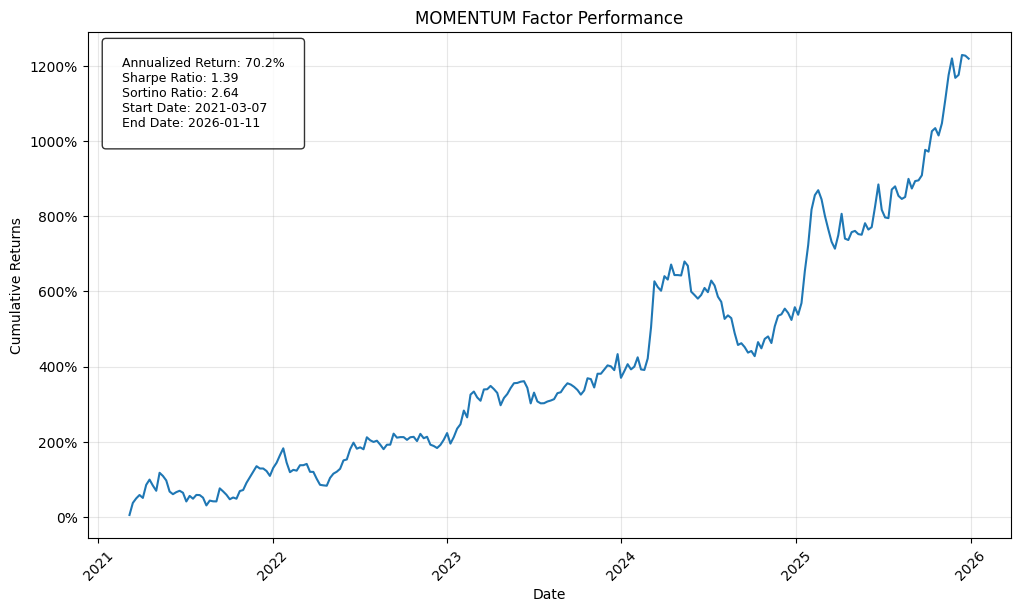

In [5]:
momentum_v2 = FactorModel(df=df, factor='momentum', breakpoint=0.25, min_assets=30, weighting_method='equal')

momentum_lookback_periods = 3
daily_lookback_period = momentum_lookback_periods * 7

# for each asset, find the trailing daily_lookback_period vol score; this is amended to derive based on daily returns, then gets resampled to weekly
def calculate_metrics(group):
    group['price_pct_change'] = group['price'].pct_change()
    # Rolling volatility adjustment
    # Mean return / std of returns over lookback period
    rolling_mean = group['price_pct_change'].rolling(
        window=daily_lookback_period,
        min_periods=daily_lookback_period
    ).mean()
    
    rolling_std = group['price_pct_change'].rolling(
        window=daily_lookback_period,
        min_periods=daily_lookback_period
    ).std()
    
    # Vol ratio (handle division by zero); Essentially a sharpe ratio
    group['vol_ratio'] = np.where(
        rolling_std > 0,
        np.abs(rolling_mean) / rolling_std,
        0
    )

    # Calculate raw momentum (compound return over lookback)
    group['raw_momentum'] = group['price_pct_change'].rolling(
        window=daily_lookback_period,
        min_periods=daily_lookback_period
    ).apply(lambda x: (1 + x).prod() - 1, raw=True)

    group['filtered_momentum'] = group['raw_momentum'] * group['vol_ratio']
    
    return group

momentum_v2.df = momentum_v2.df.groupby('asset', group_keys=False).apply(calculate_metrics)

momentum_metric_agg_method_map = {
    'price': 'last',
    'mc': 'last',
    '24h_volume': 'sum',
    'vol_ratio': 'last',
    'filtered_momentum': 'last',
}

momentum_v2.resample('W', momentum_metric_agg_method_map)
momentum_v2.calculate_price_pct_change(periods=1)
momentum_v2.calculate_price_pct_change(periods=momentum_lookback_periods)

# apply t_minus_1 calculations here
momentum_v2.get_t_minus_1_metrics(metrics=['mc', '24h_volume', f'price_pct_change_p{momentum_lookback_periods}', 'vol_ratio', 'filtered_momentum']) # t minus 1 for mc and 24h_volume
# apply eligibility criteria after calculating metrics
momentum_v2.market_cap_threshold(threshold=100000000) # 100,000,000
momentum_v2.liquidity_threshold(threshold=35000000) # $5M / day
momentum_v2.minimum_lifetime(days=30)
momentum_v2.df['variance'] = momentum_v2.df.groupby('asset')['price_pct_change_p1'].transform('var')
momentum_v2.df['inverse_variance'] = 1 / momentum_v2.df['variance']


for date, group in momentum_v2.df.groupby('date'):
    momentum_group = group.dropna(subset=['mc_t_minus_1', 'price_pct_change_p1', f'price_pct_change_p{momentum_lookback_periods}_t_minus_1', 'filtered_momentum_t_minus_1'])
    high_momentum = momentum_group.nlargest(int(len(momentum_group) * momentum_v2.breakpoint), 'filtered_momentum_t_minus_1') # ranking by filtered momentum
    low_momentum = momentum_group.nsmallest(int(len(momentum_group) * momentum_v2.breakpoint), 'filtered_momentum_t_minus_1') # ranking by filtered momentum

    if len(low_momentum) < momentum_v2.min_assets / 2 and len(high_momentum) < momentum_v2.min_assets / 2:
        continue
    else:
        if momentum_v2.weighting_method == 'equal':
            weighted_avg = lambda df: df['price_pct_change_p1'].mean() # equal weighted avg returns
        elif momentum_v2.weighting_method == 'market_cap':
            weighted_avg = lambda df: (df['mc_t_minus_1'] * df['price_pct_change_p1']).sum() / df['mc_t_minus_1'].sum()
        elif momentum_v2.weighting_method == 'inverse_variance':
            weighted_avg = lambda df: (df['inverse_variance'] * df['price_pct_change_p1']).sum() / df['inverse_variance'].sum()
        else: 
            raise ValueError(f"Invalid weighting method: {momentum_v2.weighting_method}")
            
        long_asset_details = {}
        short_asset_details = {}
        # iterate through small and parse out asset and weighting
        for _, row in high_momentum.iterrows():
            asset = row['asset']
            if momentum_v2.weighting_method == 'equal':
                weighting = 1 / len(high_momentum)
            elif momentum_v2.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / high_momentum['mc_t_minus_1'].sum()
            elif momentum_v2.weighting_method == 'inverse_variance':
                weighting = row['inverse_variance'] / high_momentum['inverse_variance'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {momentum_v2.weighting_method}")

            long_asset_details[asset] = {'weighting': weighting, 'price_pct_change': row['price_pct_change_p1'], 'trailing_price_pct_change': row[f'price_pct_change_p{momentum_lookback_periods}_t_minus_1'], 'filtered_momentum': row['filtered_momentum_t_minus_1']}

        for _, row in low_momentum.iterrows():
            asset = row['asset']
            if momentum_v2.weighting_method == 'equal':
                weighting = 1 / len(low_momentum)
            elif momentum_v2.weighting_method == 'market_cap':
                weighting = row['mc_t_minus_1'] / low_momentum['mc_t_minus_1'].sum()
            elif momentum_v2.weighting_method == 'inverse_variance':
                weighting = row['inverse_variance'] / low_momentum['inverse_variance'].sum()
            else:
                raise ValueError(f"Invalid weighting method: {momentum_v2.weighting_method}")

            short_asset_details[asset] = {'weighting': weighting, 'price_pct_change': row['price_pct_change_p1'], 'trailing_price_pct_change': row[f'price_pct_change_p{momentum_lookback_periods}_t_minus_1'], 'filtered_momentum': row['filtered_momentum_t_minus_1']}
        
        momentum_v2.factor_assets[date] = {
            'long_portfolio': long_asset_details,
            'short_portfolio': short_asset_details
        }

        momentum_v2.factor_returns[date] = weighted_avg(high_momentum) - weighted_avg(low_momentum)
        momentum_v2.long_portfolio_returns[date] = weighted_avg(high_momentum)
        momentum_v2.short_portfolio_returns[date] = weighted_avg(low_momentum)
        
momentum_factor_asset_cnts = {}
for key in momentum_v2.factor_assets.keys():
    momentum_factor_asset_cnts[key] = len(momentum_v2.factor_assets[key]['long_portfolio']) + len(momentum_v2.factor_assets[key]['short_portfolio'])


momentum_raw_returns_df = pd.DataFrame({
    'date': list(momentum_v2.factor_returns.keys()),
    'momentum_v2': list(momentum_v2.factor_returns.values())
}).set_index('date')
momentum_returns_df = cumulative_returns(momentum_v2.factor_returns)
momentum_returns_df = momentum_returns_df[:-1]
momentum_long_only_returns_df = cumulative_returns(momentum_v2.long_portfolio_returns)
momentum_long_only_returns_df = momentum_long_only_returns_df[:-1]
momentum_short_only_returns_df = cumulative_returns(momentum_v2.short_portfolio_returns)
momentum_short_only_returns_df = momentum_short_only_returns_df[:-1]

sharpe_ratio = (momentum_returns_df['value'].mean() / momentum_returns_df['value'].std()) * np.sqrt(52)

momentum_v2_downside_returns = momentum_raw_returns_df[momentum_raw_returns_df['momentum_v2'] < 0]
sortino_ratio = (momentum_raw_returns_df['momentum_v2'].mean() / momentum_v2_downside_returns['momentum_v2'].std()) * np.sqrt(52)

volatility = momentum_raw_returns_df['momentum_v2'].std()
annualized_vol = volatility * np.sqrt(52)

momentum_annualized_return, momentum_cumulative_returns, momentum_years = calculate_annualized_return(momentum_v2, momentum_returns_df)

momentum_v2.results_dict = {
    'cumulative_returns': momentum_cumulative_returns,
    'annualized_return': momentum_annualized_return,
    'years': momentum_years,
    'long_only_returns': momentum_long_only_returns_df['cumulative_returns'].iloc[-1],
    'short_only_returns': momentum_short_only_returns_df['cumulative_returns'].iloc[-1],
    'trailing_momentum_lookback_periods': momentum_lookback_periods,
    'sharpe_ratio': sharpe_ratio,
    'sortino_ratio': sortino_ratio,
    'start_date': list(momentum_v2.factor_returns.keys())[0].strftime('%Y-%m-%d'),
    'end_date': list(momentum_v2.factor_returns.keys())[-1].strftime('%Y-%m-%d'),
}

plot_cumulative_returns(momentum_returns_df, momentum_v2)

# momentum_logger = Logger(log_dir='factor_logs', factor_model=momentum_v2)
# momentum_logger.log_results(momentum_v2.results_dict)

In [6]:
momentum_factor_returns_df = pd.DataFrame(
    list(momentum_v2.factor_returns.items()), 
    columns=['date', 'momentum_v2']
).set_index('date')
momentum_factor_returns_df

,momentum_v2
date,
2021-03-07,0.054842
2021-03-14,0.303920
2021-03-21,0.087507
2021-03-28,0.060443
2021-04-04,-0.048803
...,...
2025-12-14,0.041367
2025-12-21,-0.001324
2025-12-28,-0.006006


In [15]:
momentum_factor_returns_df[
    (momentum_factor_returns_df.index.year == 2025) | (momentum_factor_returns_df.index.year == 2026)
].sort_values(by='momentum_v2')

,momentum_v2
date,
2025-04-13,-0.072744
2025-06-29,-0.068456
2026-01-04,-0.061446
2025-03-02,-0.046178
2025-03-09,-0.039426
2025-11-30,-0.039204
2025-03-16,-0.038722
2025-01-05,-0.030476
2025-08-31,-0.025737


NameError: name 'monthly_metrics_df' is not defined